## Logistic Regression Implementation on (scaled) non-reduced dataset

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 42

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('CleanedData/dataset_preprocessed.csv')

Take sample for (initial) tests

In [4]:
df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
#df_scaled_sample = df_scaled

Train-Test Split

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [6]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [7]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [8]:
predictions = model.predict(X_test)

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

Metrics for LR_original:
Accuracy: 0.7650
Weighted F1: 0.7465
Weighted Precision: 0.7628
Weighted Recall: 0.7650
Macro-Averaged Precision: 0.5285
Macro-Averaged Recall: 0.5034
F1: [0.         0.81853282 0.69117647]
Precision: [0.         0.73103448 0.85454545]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.73      0.93      0.82       114
     Class 2       0.85      0.58      0.69        81

    accuracy                           0.77       200
   macro avg       0.53      0.50      0.50       200
weighted avg       0.76      0.77      0.75       200

Confusion Matrix


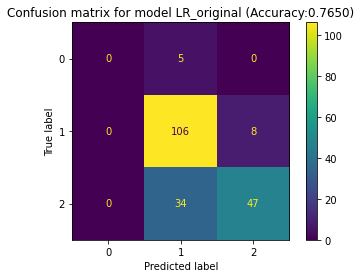

In [9]:
model_metrics = calculate_metrics('LR_original', y_test, predictions)

In [10]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [11]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [12]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 100, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.78


Results of best models Grid Search CV

In [13]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                                params  mean_test_score
154  {'C': 100, 'max_iter': 500, 'penalty': 'l2', '...          0.75625
166  {'C': 100, 'max_iter': 5000, 'penalty': 'l2', ...          0.75625
142  {'C': 100, 'max_iter': 10, 'penalty': 'l2', 's...          0.75625
164  {'C': 100, 'max_iter': 5000, 'penalty': 'l1', ...          0.75625
144  {'C': 100, 'max_iter': 100, 'penalty': 'l1', '...          0.75625


Metrics for LR_CV1_best:
Accuracy: 0.7800
Weighted F1: 0.7676
Weighted Precision: 0.7625
Weighted Recall: 0.7800
Macro-Averaged Precision: 0.5231
Macro-Averaged Recall: 0.5229
F1: [0.         0.81967213 0.74172185]
Precision: [0.         0.76923077 0.8       ]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.77      0.88      0.82       114
     Class 2       0.80      0.69      0.74        81

    accuracy                           0.78       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.76      0.78      0.77       200

Confusion Matrix


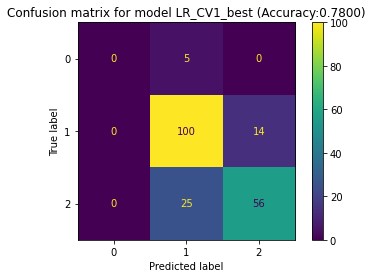

In [14]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy with Stratified K-Fold: 0.79


Results of the best model 

In [16]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.79


Results of best models Grid Search CV

In [17]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
84   {'C': 1, 'max_iter': 10, 'penalty': 'l1', 'sol...          0.74250
108  {'C': 1, 'max_iter': 5000, 'penalty': 'l1', 's...          0.74125
92   {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'so...          0.74125
96   {'C': 1, 'max_iter': 500, 'penalty': 'l1', 'so...          0.74125
100  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...          0.74125


Metrics for LR_skf_best:
Accuracy: 0.7900
Weighted F1: 0.7745
Weighted Precision: 0.7826
Weighted Recall: 0.7900
Macro-Averaged Precision: 0.5413
Macro-Averaged Recall: 0.5239
F1: [0.         0.83464567 0.73758865]
Precision: [0.         0.75714286 0.86666667]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.76      0.93      0.83       114
     Class 2       0.87      0.64      0.74        81

    accuracy                           0.79       200
   macro avg       0.54      0.52      0.52       200
weighted avg       0.78      0.79      0.77       200

Confusion Matrix


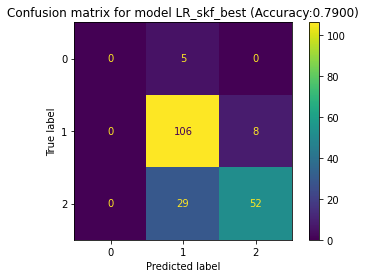

In [18]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [19]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [20]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 23:06:33,455] A new study created in memory with name: no-name-606132d9-d2ca-46ef-b4d4-191a62c70eed
[I 2024-06-04 23:06:33,490] Trial 0 finished with value: 0.76 and parameters: {'penalty': 'l2', 'C': 1.5702970884055387, 'max_iter': 639, 'solver': 'liblinear'}. Best is trial 0 with value: 0.76.
[I 2024-06-04 23:06:33,560] Trial 1 finished with value: 0.745 and parameters: {'penalty': 'l2', 'C': 0.6358358856676253, 'max_iter': 737, 'solver': 'saga'}. Best is trial 0 with value: 0.76.
[I 2024-06-04 23:06:33,591] Trial 2 finished with value: 0.57 and parameters: {'penalty': 'l1', 'C': 0.035113563139704075, 'max_iter': 265, 'solver': 'saga'}. Best is trial 0 with value: 0.76.
[I 2024-06-04 23:06:33,775] Trial 3 finished with value: 0.77 and parameters: {'penalty': 'l1', 'C': 0.6847920095574779, 'max_iter': 225, 'solver': 'saga'}. Best is trial 3 with value: 0.77.
[I 2024-06-04 23:06:33,784] Trial 4 finished with value: 0.685 and parameters: {'penalty': 'l2', 'C': 0.0397211072

Best Hyperparameters: {'penalty': 'l1', 'C': 3.8842777547031417, 'max_iter': 661, 'solver': 'liblinear'}
Best Accuracy: 0.805


In [21]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
87,87,0.805,2024-06-04 23:06:38.455979,2024-06-04 23:06:38.499976,0 days 00:00:00.043997,3.273302,522,l1,liblinear,COMPLETE
153,153,0.805,2024-06-04 23:06:42.262634,2024-06-04 23:06:42.318664,0 days 00:00:00.056030,4.030918,539,l1,liblinear,COMPLETE
13,13,0.805,2024-06-04 23:06:34.632292,2024-06-04 23:06:34.686288,0 days 00:00:00.053996,3.884278,661,l1,liblinear,COMPLETE
193,193,0.800,2024-06-04 23:06:47.256985,2024-06-04 23:06:47.430957,0 days 00:00:00.173972,3.002273,216,l1,saga,COMPLETE
10,10,0.800,2024-06-04 23:06:34.294320,2024-06-04 23:06:34.613297,0 days 00:00:00.318977,3.063462,421,l1,saga,COMPLETE
143,143,0.795,2024-06-04 23:06:41.723723,2024-06-04 23:06:41.747711,0 days 00:00:00.023988,2.121206,508,l1,liblinear,COMPLETE
189,189,0.795,2024-06-04 23:06:45.608110,2024-06-04 23:06:46.019073,0 days 00:00:00.410963,3.577839,546,l1,saga,COMPLETE
167,167,0.795,2024-06-04 23:06:43.769546,2024-06-04 23:06:44.304471,0 days 00:00:00.534925,2.628351,693,l1,saga,COMPLETE
113,113,0.795,2024-06-04 23:06:39.963822,2024-06-04 23:06:40.220835,0 days 00:00:00.257013,2.826287,332,l1,saga,COMPLETE
155,155,0.795,2024-06-04 23:06:42.326651,2024-06-04 23:06:42.397667,0 days 00:00:00.071016,8.978557,573,l2,saga,COMPLETE


Metrics for LR_OPT1_best:
Accuracy: 0.8050
Weighted F1: 0.7925
Weighted Precision: 0.7886
Weighted Recall: 0.8050
Macro-Averaged Precision: 0.5423
Macro-Averaged Recall: 0.5399
F1: [0.         0.84081633 0.77333333]
Precision: [0.         0.78625954 0.84057971]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.79      0.90      0.84       114
     Class 2       0.84      0.72      0.77        81

    accuracy                           0.81       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.79      0.81      0.79       200

Confusion Matrix


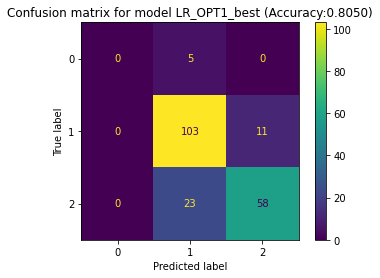

In [22]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT1_best', y_test, predictions_opt1)])

In [23]:
study.best_params

{'penalty': 'l1',
 'C': 3.8842777547031417,
 'max_iter': 661,
 'solver': 'liblinear'}

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
optuna.visualization.plot_parallel_coordinate(study)

In [26]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [27]:
optuna.visualization.plot_param_importances(study)

In [28]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [29]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [30]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 23:06:49,830] A new study created in memory with name: no-name-15a888bc-e9ee-4f00-a1d3-54fba43f209e
[I 2024-06-04 23:06:50,240] Trial 0 finished with value: 0.78 and parameters: {'l1_ratio': 0.3745401188473625, 'penalty': 'elasticnet', 'C': 63.512210106407046, 'max_iter': 759, 'solver': 'saga'}. Best is trial 0 with value: 0.78.
[I 2024-06-04 23:06:50,261] Trial 1 finished with value: 0.64 and parameters: {'l1_ratio': 0.5986584841970366, 'penalty': 'elasticnet', 'C': 0.04207988669606638, 'max_iter': 240, 'solver': 'saga'}. Best is trial 0 with value: 0.78.
[I 2024-06-04 23:06:50,492] Trial 2 finished with value: 0.785 and parameters: {'l1_ratio': 0.05808361216819946, 'penalty': 'elasticnet', 'C': 29.154431891537552, 'max_iter': 641, 'solver': 'saga'}. Best is trial 2 with value: 0.785.
[I 2024-06-04 23:06:50,502] Trial 3 finished with value: 0.57 and parameters: {'l1_ratio': 0.7080725777960455, 'penalty': 'elasticnet', 'C': 0.012087541473056965, 'max_iter': 973, 'solver':

Best Hyperparameters: {'l1_ratio': 0.6967371653641506, 'penalty': 'elasticnet', 'C': 3.2792262899971663, 'max_iter': 890, 'solver': 'saga'}
Best Accuracy: 0.8


In [31]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
127,127,0.800,2024-06-04 23:07:07.632592,2024-06-04 23:07:07.755582,0 days 00:00:00.122990,3.279226,0.696737,890,elasticnet,saga,COMPLETE
139,139,0.800,2024-06-04 23:07:09.424451,2024-06-04 23:07:09.550438,0 days 00:00:00.125987,4.898621,0.328665,777,elasticnet,saga,COMPLETE
186,186,0.800,2024-06-04 23:07:16.558692,2024-06-04 23:07:16.695716,0 days 00:00:00.137024,3.028574,0.755137,734,elasticnet,saga,COMPLETE
107,107,0.795,2024-06-04 23:07:04.625219,2024-06-04 23:07:04.783205,0 days 00:00:00.157986,4.373101,0.714596,352,elasticnet,saga,COMPLETE
120,120,0.795,2024-06-04 23:07:06.693701,2024-06-04 23:07:06.782694,0 days 00:00:00.088993,3.742423,0.388170,512,elasticnet,saga,COMPLETE
42,42,0.795,2024-06-04 23:06:55.726283,2024-06-04 23:06:55.822307,0 days 00:00:00.096024,27.728242,0.818015,106,elasticnet,saga,COMPLETE
78,78,0.795,2024-06-04 23:07:00.056964,2024-06-04 23:07:00.176954,0 days 00:00:00.119990,7.759048,0.195243,352,elasticnet,saga,COMPLETE
181,181,0.795,2024-06-04 23:07:16.193755,2024-06-04 23:07:16.306746,0 days 00:00:00.112991,2.968335,0.671701,422,elasticnet,saga,COMPLETE
182,182,0.795,2024-06-04 23:07:16.307745,2024-06-04 23:07:16.392739,0 days 00:00:00.084994,4.856158,0.113558,568,elasticnet,saga,COMPLETE
116,116,0.795,2024-06-04 23:07:05.886734,2024-06-04 23:07:05.964728,0 days 00:00:00.077994,3.187423,0.374613,553,elasticnet,saga,COMPLETE


Metrics for LR_OPT2_best:
Accuracy: 0.8000
Weighted F1: 0.7860
Weighted Precision: 0.7881
Weighted Recall: 0.8000
Macro-Averaged Precision: 0.5438
Macro-Averaged Recall: 0.5334
F1: [0.         0.84       0.75862069]
Precision: [0.         0.77205882 0.859375  ]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.77      0.92      0.84       114
     Class 2       0.86      0.68      0.76        81

    accuracy                           0.80       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.79      0.80      0.79       200

Confusion Matrix


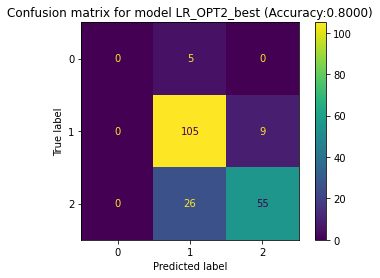

In [32]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT2_best', y_test, predictions_opt2)])

In [33]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [34]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [35]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-04 23:07:19,776] A new study created in memory with name: no-name-80e34a24-fa38-4fe8-9024-648767c8f07d
[I 2024-06-04 23:07:20,399] Trial 0 finished with value: 0.775 and parameters: {'l1_ratio': 0.3745401188473625, 'penalty': 'elasticnet', 'C': 95.07192349792751, 'max_iter': 759, 'solver': 'saga'}. Best is trial 0 with value: 0.775.
[I 2024-06-04 23:07:20,602] Trial 1 finished with value: 0.79 and parameters: {'l1_ratio': 0.5986584841970366, 'penalty': 'elasticnet', 'C': 15.610303857839227, 'max_iter': 240, 'solver': 'saga'}. Best is trial 1 with value: 0.79.
[I 2024-06-04 23:07:21,018] Trial 2 finished with value: 0.78 and parameters: {'l1_ratio': 0.05808361216819946, 'penalty': 'elasticnet', 'C': 86.61895281603577, 'max_iter': 641, 'solver': 'saga'}. Best is trial 1 with value: 0.79.
[I 2024-06-04 23:07:21,115] Trial 3 finished with value: 0.78 and parameters: {'l1_ratio': 0.7080725777960455, 'penalty': 'elasticnet', 'C': 2.0682435846372864, 'max_iter': 973, 'solver': 'sag

Best Hyperparameters: {'l1_ratio': 0.09367476782809248, 'penalty': 'elasticnet', 'C': 36.77790314791275, 'max_iter': 338, 'solver': 'saga'}
Best Accuracy: 0.8


In [36]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
152,152,0.800,2024-06-04 23:08:06.618276,2024-06-04 23:08:06.751228,0 days 00:00:00.132952,46.871378,0.011354,150,elasticnet,saga,COMPLETE
74,74,0.800,2024-06-04 23:07:41.204366,2024-06-04 23:07:41.462353,0 days 00:00:00.257987,36.777903,0.093675,338,elasticnet,saga,COMPLETE
123,123,0.795,2024-06-04 23:07:57.732003,2024-06-04 23:07:57.834992,0 days 00:00:00.102989,10.086792,0.069361,116,elasticnet,saga,COMPLETE
111,111,0.795,2024-06-04 23:07:54.271297,2024-06-04 23:07:54.353285,0 days 00:00:00.081988,4.609804,0.116073,136,elasticnet,saga,COMPLETE
157,157,0.795,2024-06-04 23:08:07.803177,2024-06-04 23:08:08.256140,0 days 00:00:00.452963,4.325560,0.969879,902,elasticnet,saga,COMPLETE
48,48,0.795,2024-06-04 23:07:33.781441,2024-06-04 23:07:33.860443,0 days 00:00:00.079002,3.698326,0.284840,649,elasticnet,saga,COMPLETE
36,36,0.795,2024-06-04 23:07:29.793392,2024-06-04 23:07:29.916375,0 days 00:00:00.122983,7.707221,0.228798,361,elasticnet,saga,COMPLETE
168,168,0.795,2024-06-04 23:08:11.780366,2024-06-04 23:08:12.097339,0 days 00:00:00.316973,16.270068,0.684731,920,elasticnet,saga,COMPLETE
58,58,0.795,2024-06-04 23:07:36.095762,2024-06-04 23:07:36.406766,0 days 00:00:00.311004,17.444899,0.645173,722,elasticnet,saga,COMPLETE
21,21,0.795,2024-06-04 23:07:25.896712,2024-06-04 23:07:26.169686,0 days 00:00:00.272974,28.100642,0.356753,588,elasticnet,saga,COMPLETE


Metrics for LR_OPT3_best:
Accuracy: 0.8000
Weighted F1: 0.7877
Weighted Precision: 0.7828
Weighted Recall: 0.8000
Macro-Averaged Precision: 0.5377
Macro-Averaged Recall: 0.5369
F1: [0.         0.83606557 0.76821192]
Precision: [0.         0.78461538 0.82857143]
classification report
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         5
     Class 1       0.78      0.89      0.84       114
     Class 2       0.83      0.72      0.77        81

    accuracy                           0.80       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.78      0.80      0.79       200

Confusion Matrix


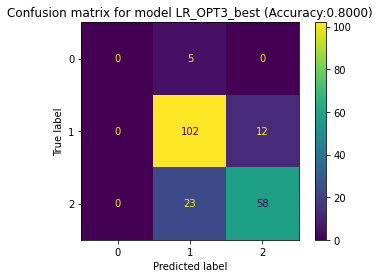

In [37]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT3_best', y_test, predictions_opt3)])

end

In [38]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR_original,0.765,0.746490,0.762781,0.765,0.528527,0.503357,[0. 0.81853282 0.69117647],[0. 0.73103448 0.85454545]
LR_CV1_best,0.780,0.767610,0.762462,0.780,0.523077,0.522850,[0. 0.81967213 0.74172185],[0. 0.76923077 0.8 ]
LR_skf_best,0.790,0.774471,0.782571,0.790,0.541270,0.523933,[0. 0.83464567 0.73758865],[0. 0.75714286 0.86666667]
LR_OPT1_best,0.805,0.792465,0.788603,0.805,0.542280,0.539853,[0. 0.84081633 0.77333333],[0. 0.78625954 0.84057971]
LR_OPT2_best,0.800,0.786041,0.788120,0.800,0.543811,0.533355,[0. 0.84 0.75862069],[0. 0.77205882 0.859375 ]
LR_OPT3_best,0.800,0.787683,0.782802,0.800,0.537729,0.536929,[0. 0.83606557 0.76821192],[0. 0.78461538 0.82857143]
